


- download the data from Tauxe et al. (2015; DOI: 10.1016/J.EPSL.2014.12.034; MagIC id:16749) using the wget.download command as in Exercise 1.
- Move the downloaded data file to a directory called 'MagIC\_example\_3'

- Unpack it with ipmag.download_magic()
- make a figure with these elements for the interval 40 m to 160 m:
    - magstrat time scale plot from 2 to 7 Ma
    - inclinations (dir\_inc) from the 20mT step in the measurements table  against composite_depth as blue dots
    - inclinations (dir\_inc) from the specimens table against composite depth as red triangles. 
    - put on dotted lines for the GAD inclination
- use ipmag.ani_depthplot to plot the anisotropy data against depth in the Hole.  

## Magnetostratigraphy

In this example, we are going to visualize data from this IODP study: 

> Tauxe, L., Sugisaki, S., Jiménez-Espejo, F., Escutia, C., Cook, C. P., van de Flierdt, T., & Iwai, M. (2015). Geology of the Wilkes Land sub-basin and stability of the East Antarctic Ice Sheet: Insights from rock magnetism at IODP Site U1361. Earth and Planetary Science Letters, 412, 61– 69. https://doi.org/10.1016/j.epsl.2014.12.034

Our goal is to do make a figure that shows the following between the meter levels of 40 and 160 m depth in this core:

- geomagnetic polarity timescale plotted from 2 to 7 Ma
- inclinations (`dir_inc`) from the 20 mT step in the measurements table against depth (let's make them blue dots)
- inclinations (`dir_inc`) from the specimens table against depth (let's make them red triangles)
- lines for the GAD inclination (let's make them dotted)

To start with, we need to get the data from MagIC. We can do this using the DOI of the paper and the `ipmag.download_magic_from_doi()` function to get the data.

## Import the functions we need

In [31]:
import pmagpy.ipmag as ipmag
import pmagpy.pmagplotlib as pmagplotlib
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt

In [2]:
ipmag.download_magic_from_doi('10.1016/j.epsl.2014.12.034')

16761/magic_contribution_16761.txt extracted to magic_contribution.txt 



(True, '')

## Download the data

Now that we have got ahold of the MagIC contribution, we can use the `ipmag.download_magic()` function to unpack it into the different MagIC tables. We can either do this into the current directory or specify a specific directory (one of the parameters of the function). Let's just keep the tables in the current directory for this example.

In [4]:
ipmag.download_magic('magic_contribution.txt',print_progress=False)

1  records written to file  /Users/unimos/0000_Github/2023_MagIC_Tutorial/3_PmagPy_in_action/magnetostratigraphy/contribution.txt
1  records written to file  /Users/unimos/0000_Github/2023_MagIC_Tutorial/3_PmagPy_in_action/magnetostratigraphy/locations.txt
5943  records written to file  /Users/unimos/0000_Github/2023_MagIC_Tutorial/3_PmagPy_in_action/magnetostratigraphy/sites.txt
2436  records written to file  /Users/unimos/0000_Github/2023_MagIC_Tutorial/3_PmagPy_in_action/magnetostratigraphy/samples.txt
2573  records written to file  /Users/unimos/0000_Github/2023_MagIC_Tutorial/3_PmagPy_in_action/magnetostratigraphy/specimens.txt
4697  records written to file  /Users/unimos/0000_Github/2023_MagIC_Tutorial/3_PmagPy_in_action/magnetostratigraphy/measurements.txt
60  records written to file  /Users/unimos/0000_Github/2023_MagIC_Tutorial/3_PmagPy_in_action/magnetostratigraphy/ages.txt


True

2573  specimens records read in
All


(True, [])

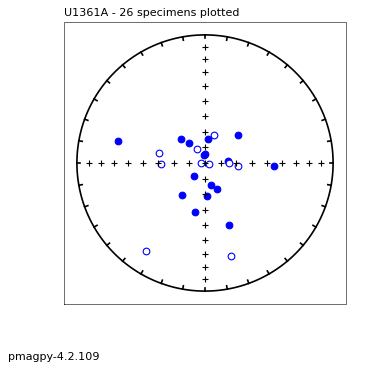

In [11]:
ipmag.eqarea_magic(in_file='specimens.txt',save_plots=False)

## Read in the data tables

Let's import all of the different data tables using `pandas`. For each one, note that we tell pandas that these are tab delimited files `sep='\t'` and that the column names are in the second row (python counts from `0` so this is `header=1`; you can also think of it as skipping 1 header row)

In [6]:
measurements = pd.read_csv('measurements.txt',sep='\t',header=1)
sites = pd.read_csv('sites.txt',sep='\t',header=1)
specimens = pd.read_csv('specimens.txt',sep='\t',header=1)
ages = pd.read_csv('ages.txt',sep='\t',header=1)

## Wrangle the data

### Get core depth into every DataFrame

The depth of a particular specimen/site in MagIC is stored in the sites.txt table.  We need to merge the data from that table into the specimens/measurements tables.  To do that we need to do a couple things:

First, we need a common key.  Because the specimen/sample/site names are the same for an IODP record, we can make a column in the specimen/measurements dataframes labled 'site' that is the same as the specimen.  

In [29]:
measurements['site'] = measurements['specimen']
specimens['site'] = specimens['specimen']

Then we can make a depths dataframe with the core_depth information linked to site and merge that information into the specimens and measurements tables with `pd.merge()`

In [34]:
depths = sites[['site','core_depth']]
specimens = pd.merge(specimens,depths,on='site')
measurements = pd.merge(measurements,depths,on='site')

### Filter out the 20 mT step

We are interested in investigating the 20 mT measurement step. We can create a new dataframe that is filtered to be the values in the measurements table where `'treat_ac_field'` is equal to `0.02` (given the MagIC uses SI units so this is 0.02 T which is 20 mT). 

`measurements['treat_ac_field']==0.02` tells us whether a given row has this value in the `'treat_ac_field'` column by giving a True, False list (known as boolean indexing). We can then take the True/False list and tell pandas to give us the values where it is True by putting it inside the `[ ]` index brackets.

In [35]:
measurements_20mT = measurements[measurements['treat_ac_field']==0.02] 

Let's look at the first 5 rows of the filtered data to see that the filtering worked using the `.head()` function applied to the `measurements_20mT` dataframe.

In [36]:
measurements_20mT.head()

,analysts,citations,description,dir_csd,dir_dec,dir_inc,experiment,hyst_charging_mode,hyst_loop,hyst_sweep_rate,instrument_codes,magn_mass,magn_moment,magn_r2_det,magn_uncal,magn_volume,magn_x_sigma,magn_xyz_sigma,magn_y_sigma,magn_z_sigma,meas_field_ac,meas_field_dc,meas_freq,meas_n_orient,meas_orient_phi,meas_orient_theta,meas_pos_x,meas_pos_y,meas_pos_z,meas_temp,meas_temp_change,measurement,method_codes,quality,sequence,software_packages,specimen,standard,susc_chi_mass,susc_chi_qdr_mass,susc_chi_qdr_volume,susc_chi_volume,timestamp,treat_ac_field,treat_ac_field_dc_off,treat_ac_field_dc_on,treat_ac_field_decay_rate,treat_dc_field,treat_dc_field_ac_off,treat_dc_field_ac_on,treat_dc_field_decay_rate,treat_dc_field_phi,treat_dc_field_theta,treat_mw_integral,treat_mw_power,treat_mw_time,treat_step_num,treat_temp,treat_temp_dc_off,treat_temp_dc_on,treat_temp_decay_rate,site,core_depth_x,core_depth_y,core_depth
0,NaN,This study,NaN,NaN,31.3,-66.1,318-U1361A-001H-2A-0-1-LT-AF-Z,NaN,NaN,NaN,NaN,NaN,2.974000e-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,273,NaN,318-U1361A-001H-2A-0-1-LT-AF-Z-1,LT-AF-Z,g,1,pmagpy-2.93,318-U1361A-001H_2A-0.1,u,NaN,NaN,NaN,NaN,2010-02-26T13:48:00Z,0.02,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,1,273.0,NaN,NaN,NaN,318-U1361A-001H_2A-0.1,1.60,1.60,1.60
1,NaN,This study,NaN,NaN,44.9,-70.6,318-U1361A-001H-2A-0-15-LT-AF-Z,NaN,NaN,NaN,NaN,NaN,3.071000e-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,273,NaN,318-U1361A-001H-2A-0-15-LT-AF-Z-1,LT-AF-Z,g,2,pmagpy-2.93,318-U1361A-001H_2A-0.15,u,NaN,NaN,NaN,NaN,2010-02-26T13:48:00Z,0.02,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,1,273.0,NaN,NaN,NaN,318-U1361A-001H_2A-0.15,1.65,1.65,1.65
2,NaN,This study,NaN,NaN,49.7,-69.9,318-U1361A-001H-2A-0-2-LT-AF-Z,NaN,NaN,NaN,NaN,NaN,3.404000e-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,273,NaN,318-U1361A-001H-2A-0-2-LT-AF-Z-1,LT-AF-Z,g,3,pmagpy-2.93,318-U1361A-001H_2A-0.2,u,NaN,NaN,NaN,NaN,2010-02-26T13:48:00Z,0.02,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,1,273.0,NaN,NaN,NaN,318-U1361A-001H_2A-0.2,1.70,1.70,1.70
3,NaN,This study,NaN,NaN,44.0,-69.3,318-U1361A-001H-2A-0-25-LT-AF-Z,NaN,NaN,NaN,NaN,NaN,4.026000e-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,273,NaN,318-U1361A-001H-2A-0-25-LT-AF-Z-1,LT-AF-Z,g,4,pmagpy-2.93,318-U1361A-001H_2A-0.25,u,NaN,NaN,NaN,NaN,2010-02-26T13:48:00Z,0.02,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,1,273.0,NaN,NaN,NaN,318-U1361A-001H_2A-0.25,1.75,1.75,1.75
4,NaN,This study,NaN,NaN,52.3,-65.2,318-U1361A-001H-2A-0-3-LT-AF-Z,NaN,NaN,NaN,NaN,NaN,5.061000e-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,273,NaN,318-U1361A-001H-2A-0-3-LT-AF-Z-1,LT-AF-Z,g,5,pmagpy-2.93,318-U1361A-001H_2A-0.3,u,NaN,NaN,NaN,NaN,2010-02-26T13:48:00Z,0.02,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,1,273.0,NaN,NaN,NaN,318-U1361A-001H_2A-0.3,1.80,1.80,1.80


### Calculate the dipole field

We want to calculate the geocentric axial dipole field for the site latitude. First, we can extract the site latitude. There is only going to be one value as all the data are from the same core.

In [41]:
site_lat = sites['lat'].unique()[0]
site_lat

-64.2457

We can then use the `ipmag` function `ipmag.inc_from_lat()` to use the dipole equation to calculate the expected inclination at this latitude. This is a quite simple function. Let's use the `??` to interogate not only the docstring associated with the function, but the guts inside.

In [46]:
ipmag.inc_from_lat??

Signature: ipmag.inc_from_lat(lat)
Source:   
def inc_from_lat(lat):
    """
    Calculate inclination predicted from latitude using the dipole equation.

    Parameter:
        lat : latitude in degrees

    Returns:
        inclination calculated from latitude using the dipole equation

    Examples:
        Calculate the inclination implied by an latitude of 45 degrees:
        >>> ipmag.inc_from_lat(45)
        63.434948822922
    """
    rad = np.pi/180.0
    inc = np.arctan(2 * np.tan(lat * rad))/rad
    return inc
File:      ~/0000_Github/PmagPy/pmagpy/ipmag.py
Type:      function


If we just run the function, the `inc` gets printed out as notebook output

In [48]:
ipmag.inc_from_lat(site_lat)

-76.43831968696897

In this case, we want to save the value to plot it, so let's assign it to a variable `gad_inc`

In [49]:
gad_inc = ipmag.inc_from_lat(site_lat)

We can then see what the `gad_inc` value is by running a cell with just that variable in it

In [50]:
gad_inc

-76.43831968696897

### Filter ages to be the reversals

There is both biostratigraphic information and interpretations of geomagnetic reversals in the ages table. Let's focus on the `method_codes` that contain `PMAG` informa

In [54]:
ages = ages[ages['method_codes'].str.contains('PMAG')]

The age table has only height (not depth) so we need to do a conversion.

In [56]:
# note that 
ages = ages[(ages['tiepoint_height']<-depth_min)&(ages['tiepoint_height']>-depth_max)]

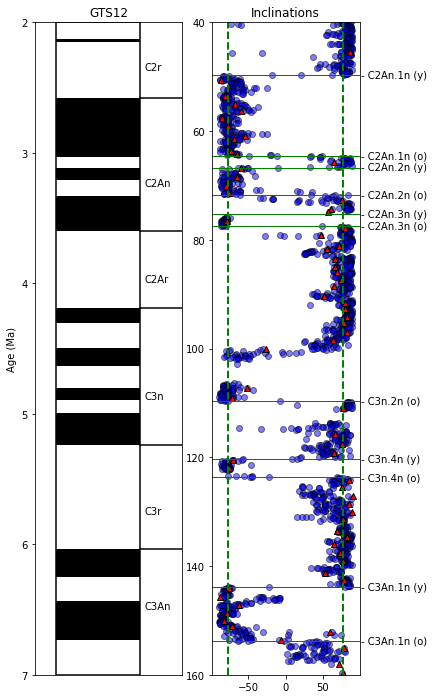

In [57]:

fig=plt.figure(1,(9,12)) # make the figure
ax1=fig.add_subplot(131) # make the first of three subplots
pmagplotlib.plot_ts(ax1,2,7,timescale='gts12') # plot on the time scale
ax2=fig.add_subplot(132) # make the second of three subplots
plt.plot(measurements_20mT.dir_inc,measurements_20mT.core_depth,'bo',markeredgecolor='black',alpha=.5)
plt.plot(specimens.dir_inc,specimens.core_depth,'r^',markeredgecolor='black')

plt.ylim(depth_max,depth_min)
# calculate the geocentric axial dipole field for the site latitude

# put it on the plot as a green dashed line
plt.axvline(gad_inc,color='green',linestyle='dashed',linewidth=2)
plt.axvline(-gad_inc,color='green',linestyle='dashed',linewidth=2)
plt.title('Inclinations')
pmagplotlib.label_tiepoints(ax2,100,ages.tiepoint.values,-1*ages.tiepoint_height.values,lines=True)
#

In [7]:
dir_path='MagIC_example_3' # set the path to your working directory
depth_min, depth_max= 40, 160 # set the core depth bounds as required
# First get the file from MagIC into your working directory:
magic_id='16761'
magic_contribution='magic_contribution_'+magic_id+'.txt' # set the file name string
ipmag.download_magic_from_id(magic_id) # download the contribution from MagIC
os.rename(magic_contribution, dir_path+'/'+magic_contribution) # move the contribution to the directory
 # unpack the file

1  records written to file  /Users/ltauxe/PmagPy/MagIC_example_3/contribution.txt
1  records written to file  /Users/ltauxe/PmagPy/MagIC_example_3/locations.txt
5943  records written to file  /Users/ltauxe/PmagPy/MagIC_example_3/sites.txt
2436  records written to file  /Users/ltauxe/PmagPy/MagIC_example_3/samples.txt
2573  records written to file  /Users/ltauxe/PmagPy/MagIC_example_3/specimens.txt
4697  records written to file  /Users/ltauxe/PmagPy/MagIC_example_3/measurements.txt
60  records written to file  /Users/ltauxe/PmagPy/MagIC_example_3/ages.txt


True

## Magstrat figure
- read in the data file as a Pandas DataFrame with pd.read_csv().  
    - All MagIC .txt files are tab delimited.  This is indicated with a sep='\t' keywork.  
    - The column headers in the second row, hence (because Python counts from zero), header=1


In [22]:
dir_path='MagIC_example_3' # set the path to your working directory
depth_min, depth_max= 40, 160 # set the core depth bounds as required
# read in the required data tables:

# filter the ages table for method codes that indicate paleomagnetic reversals:
ages_df=ages_df[ages_df['method_codes'].str.contains('PMAG')]
# filter the measurements for the 20 mT (.02 T) step
meas_df.dropna(subset=['treat_ac_field'],inplace=True)
meas_20mT=meas_df[meas_df['treat_ac_field']==0.02] 
# make the site key in the measurements and specimens dataframes
meas_20mT['site']=meas_20mT['specimen']
spec_df['site']=spec_df['specimen']
# we only want the core depth out of the sites dataframe, so we can pare it down like this:
depth_df=site_df[['site','core_depth']]
# merge the specimen, depth dataframes
spec_df=pd.merge(spec_df,depth_df,on='site')
# merge the measurements, depth dataframes
meas_20mT=pd.merge(meas_20mT,depth_df,on='site')
# filter for the desired depth range: 
spec_df=spec_df[(spec_df['core_depth']>depth_min)&(spec_df['core_depth']<depth_max)]
meas_20mT=meas_20mT[(meas_20mT['core_depth']>depth_min)&(meas_20mT['core_depth']<depth_max)]
# note that the age table has only height (not depth), so these numbers are the opposite
ages_df=ages_df[(ages_df['tiepoint_height']<-depth_min)&(ages_df['tiepoint_height']>-depth_max)]
# get the site latitude (there is only one)
lat=site_df['lat'].unique()[0]



NameError: name 'ages_df' is not defined

AttributeError: 'DataFrame' object has no attribute 'core_depth'

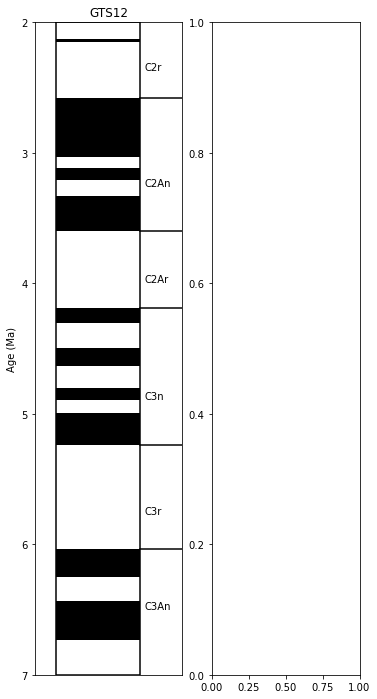

In [24]:
fig=plt.figure(1,(9,12)) # make the figure
ax1=fig.add_subplot(131) # make the first of three subplots
pmagplotlib.plot_ts(ax1,2,7,timescale='gts12') # plot on the time scale
ax2=fig.add_subplot(132) # make the second of three subplots
plt.plot(measurements_20mT.dir_inc,measurements_20mT.core_depth,'bo',markeredgecolor='black',alpha=.5)
plt.plot(spec_df.dir_inc,spec_df.core_depth,'r^',markeredgecolor='black')

plt.ylim(depth_max,depth_min)
# calculate the geocentric axial dipole field for the site latitude
gad=pmag.pinc(lat) # tan (I) = 2 tan (lat)
# put it on the plot as a green dashed line
plt.axvline(gad,color='green',linestyle='dashed',linewidth=2)
plt.axvline(-gad,color='green',linestyle='dashed',linewidth=2)
plt.title('Inclinations')
pmagplotlib.label_tiepoints(ax2,100,ages_df.tiepoint.values,-1*ages_df.tiepoint_height.values,lines=True)
#

In [7]:
dir_path='MagIC_example_3' # set the path to your working directory
depth_min, depth_max= 40, 160 # set the core depth bounds as required
# First get the file from MagIC into your working directory:
magic_id='16761'
magic_contribution='magic_contribution_'+magic_id+'.txt' # set the file name string
ipmag.download_magic_from_id(magic_id) # download the contribution from MagIC
os.rename(magic_contribution, dir_path+'/'+magic_contribution) # move the contribution to the directory
ipmag.download_magic(magic_contribution,dir_path=dir_path,print_progress=False) # unpack the file

1  records written to file  /Users/ltauxe/PmagPy/MagIC_example_3/contribution.txt
1  records written to file  /Users/ltauxe/PmagPy/MagIC_example_3/locations.txt
5943  records written to file  /Users/ltauxe/PmagPy/MagIC_example_3/sites.txt
2436  records written to file  /Users/ltauxe/PmagPy/MagIC_example_3/samples.txt
2573  records written to file  /Users/ltauxe/PmagPy/MagIC_example_3/specimens.txt
4697  records written to file  /Users/ltauxe/PmagPy/MagIC_example_3/measurements.txt
60  records written to file  /Users/ltauxe/PmagPy/MagIC_example_3/ages.txt


True

## Magstrat figure
- read in the data file as a Pandas DataFrame with pd.read_csv().  
    - All MagIC .txt files are tab delimited.  This is indicated with a sep='\t' keywork.  
    - The column headers in the second row, hence (because Python counts from zero), header=1
- the depth of a particular specimen/site in MagIC is stored in the sites.txt table.  You will have to merge the data from that table into the specimens/measurements tables.  To do that you need to do a few things:
    - you need a common key.  Because the specimen/sample/site names are the same for an IODP record, make a column in the specimen/measurements dataframes labled 'site' that is the same as the specimen.  
    - merge the two dataframes (sites and specimens/measurements) with pd.merge()

In [8]:
dir_path='MagIC_example_3' # set the path to your working directory
depth_min, depth_max= 40, 160 # set the core depth bounds as required
# read in the required data tables:
meas_df=pd.read_csv(dir_path+'/measurements.txt',sep='\t',header=1)
site_df=pd.read_csv(dir_path+'/sites.txt',sep='\t',header=1)
spec_df=pd.read_csv(dir_path+'/specimens.txt',sep='\t',header=1)
ages_df=pd.read_csv(dir_path+'/ages.txt',sep='\t',header=1)
# filter the ages table for method codes that indicate paleomagnetic reversals:
ages_df=ages_df[ages_df['method_codes'].str.contains('PMAG')]
# filter the measurements for the 20 mT (.02 T) step
meas_df.dropna(subset=['treat_ac_field'],inplace=True)
meas_20mT=meas_df[meas_df['treat_ac_field']==0.02] 
# make the site key in the measurements and specimens dataframes
meas_20mT['site']=meas_20mT['specimen']
spec_df['site']=spec_df['specimen']
# we only want the core depth out of the sites dataframe, so we can pare it down like this:
depth_df=site_df[['site','core_depth']]
# merge the specimen, depth dataframes
spec_df=pd.merge(spec_df,depth_df,on='site')
# merge the measurements, depth dataframes
meas_20mT=pd.merge(meas_20mT,depth_df,on='site')
# filter for the desired depth range: 
spec_df=spec_df[(spec_df['core_depth']>depth_min)&(spec_df['core_depth']<depth_max)]
meas_20mT=meas_20mT[(meas_20mT['core_depth']>depth_min)&(meas_20mT['core_depth']<depth_max)]
# note that the age table has only height (not depth), so these numbers are the opposite
ages_df=ages_df[(ages_df['tiepoint_height']<-depth_min)&(ages_df['tiepoint_height']>-depth_max)]
# get the site latitude (there is only one)
lat=site_df['lat'].unique()[0]



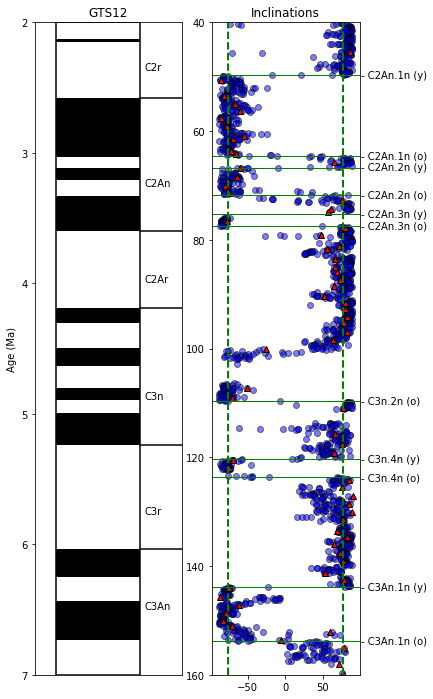

In [9]:
fig=plt.figure(1,(9,12)) # make the figure
ax1=fig.add_subplot(131) # make the first of three subplots
pmagplotlib.plot_ts(ax1,2,7,timescale='gts12') # plot on the time scale
ax2=fig.add_subplot(132) # make the second of three subplots
plt.plot(meas_20mT.dir_inc,meas_20mT.core_depth,'bo',markeredgecolor='black',alpha=.5)
plt.plot(spec_df.dir_inc,spec_df.core_depth,'r^',markeredgecolor='black')

plt.ylim(depth_max,depth_min)
# calculate the geocentric axial dipole field for the site latitude
gad=pmag.pinc(lat) # tan (I) = 2 tan (lat)
# put it on the plot as a green dashed line
plt.axvline(gad,color='green',linestyle='dashed',linewidth=2)
plt.axvline(-gad,color='green',linestyle='dashed',linewidth=2)
plt.title('Inclinations')
pmagplotlib.label_tiepoints(ax2,100,ages_df.tiepoint.values,-1*ages_df.tiepoint_height.values,lines=True)
#